## Imports des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, log_loss, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import LinearSVC,NuSVC,SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet('ckd_total.parquet')

Creation de la liste des modèles

In [4]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    HistGradientBoostingClassifier(),
    LinearSVC(),
    MLPClassifier(),]

In [5]:
df.describe()

,al,su,rbc,pc,pcc,ba,htn,dm,cad,appet,...,sg,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,274.000000,274.000000,216.000000,263.000000,272.000000,272.000000,273.000000,273.000000,273.000000,274.000000,...,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,0.912409,0.383212,0.152778,0.209125,0.110294,0.062500,0.347985,0.304029,0.080586,0.186131,...,1.018223,142.800000,54.905818,2.518909,138.181818,4.506909,12.982545,39.694545,8382.545455,4.762041
std,1.353192,1.006868,0.360609,0.407460,0.313833,0.242508,0.477206,0.460840,0.272698,0.389925,...,0.005704,76.117082,47.835743,3.410986,6.977259,2.667305,2.863256,8.823977,2886.272707,0.940719
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.005000,22.000000,1.500000,0.400000,104.000000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.015000,99.000000,27.000000,0.800000,135.000000,3.900000,10.950000,33.000000,6700.000000,4.200000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.020000,119.000000,41.000000,1.200000,139.000000,4.400000,13.500000,41.000000,8000.000000,4.762041
75%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.025000,142.000000,55.000000,2.450000,142.000000,4.900000,15.150000,46.000000,9650.000000,5.400000
max,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.025000,490.000000,322.000000,24.000000,150.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [ ]:
variables = {
    "age": "Âge",
    "bp": "Pression artérielle",
    "sg": "Gravité spécifique",
    "al": "Albumine",
    "su": "Sucre",
    "rbc": "Globules rouges Count",
    "pc": "Cellules pus",
    "pcc": "Cellules pus dans l'urine",
    "ba": "Bactéries",
    "bgr": "Glucose sanguin aléatoire",
    "bu": "Urée sanguine",
    "sc": "Créatinine sérique",
    "sod": "Sodium",
    "pot": "Potassium",
    "hemo": "Hémoglobine",
    "pcv": "Volume globulaire moyen",
    "wc": "Leucocytes",
    "rc": "Globules rouges",
    "htn": "Hypertension",
    "dm": "Diabète",
    "cad": "Maladie artérielle coronaire",
    "appet": "Appétit",
    "pe": "Œdème périphérique",
    "ane": "Anémie",
    "classification": "target"
}

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [6]:
for column in df.iloc[:,:12].columns:
    df[column] = imputer.fit_transform(df[column].to_numpy().reshape(-1,1))

## Preprocessing

Nous allons tester tous les scalers avec tous les modèles afin d'établir les plus performants

In [7]:
y = df.classification
X = df.drop(columns='classification')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

Ici on crée le pipeline de scaling

In [8]:
scalers = [
    ("Unscaled data", X),
    ("Data after standard scaling", StandardScaler().fit_transform(X)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X)),
    (
        "Data after robust scaling",
        RobustScaler(quantile_range=(25, 75)).fit_transform(X),
    ),
    (
        "Data after power transformation (Yeo-Johnson)",
        PowerTransformer(method="yeo-johnson").fit_transform(X),
    ),
    (
        "Data after quantile transformation (uniform pdf)",
        QuantileTransformer(
            output_distribution="uniform", random_state=42
        ).fit_transform(X),
    ),
    (
        "Data after quantile transformation (gaussian pdf)",
        QuantileTransformer(
            output_distribution="normal", random_state=42
        ).fit_transform(X),
    ),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X)),
]

Et ici on vient faire des prédictions en bouclant sur les scalers et les modèles avant de stocker les résultats dans un dataframe

In [12]:

log_cols=["Scaler","Classifier", "Accuracy", "Recall", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
for X in scalers :
    for clf in classifiers:
        scaler = X[0]
        X_train, X_test, y_train, y_test = train_test_split(X[1], y, random_state=42)
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        rec = recall_score(y_test, train_predictions)
        try:
            train_predictions = clf.predict_proba(X_test)
            ll = log_loss(y_test, train_predictions)
        except:
            pass
        log_entry = pd.DataFrame([[scaler, name, acc*100, rec*100, ll]], columns=log_cols)
        log = pd.concat([log,log_entry], ignore_index=True)

In [14]:
log.sort_values(['Accuracy','Recall','Log Loss'],ascending=[False,False,True]).head(50)

,Scaler,Classifier,Accuracy,Recall,Log Loss
10,Unscaled data,HistGradientBoostingClassifier,100.000000,100.000000,0.002940
23,Data after standard scaling,HistGradientBoostingClassifier,100.000000,100.000000,0.002940
24,Data after standard scaling,LinearSVC,100.000000,100.000000,0.002940
36,Data after min-max scaling,HistGradientBoostingClassifier,100.000000,100.000000,0.002940
49,Data after max-abs scaling,HistGradientBoostingClassifier,100.000000,100.000000,0.002940
62,Data after robust scaling,HistGradientBoostingClassifier,100.000000,100.000000,0.002940
63,Data after robust scaling,LinearSVC,100.000000,100.000000,0.002940
75,Data after power transformation (Yeo-Johnson),HistGradientBoostingClassifier,100.000000,100.000000,0.002940
76,Data after power transformation (Yeo-Johnson),LinearSVC,100.000000,100.000000,0.002940
88,Data after quantile transformation (uniform pdf),HistGradientBoostingClassifier,100.000000,100.000000,0.002940


In [18]:
scalers_g = log.groupby('Scaler').agg({'Accuracy':'mean', 'Log Loss':'mean'})

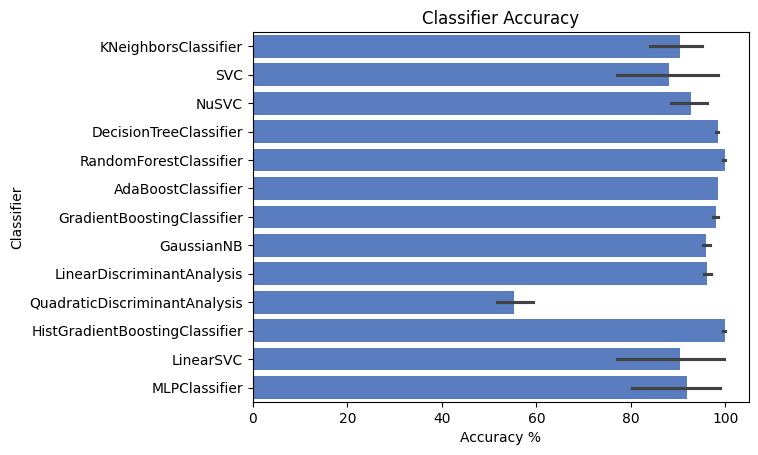

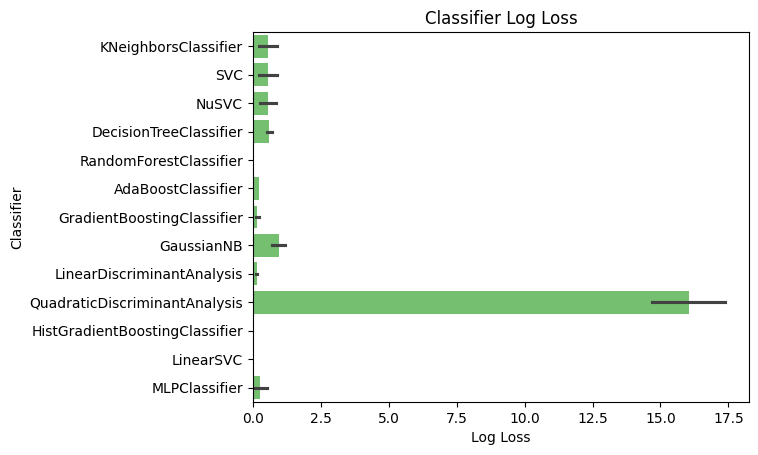

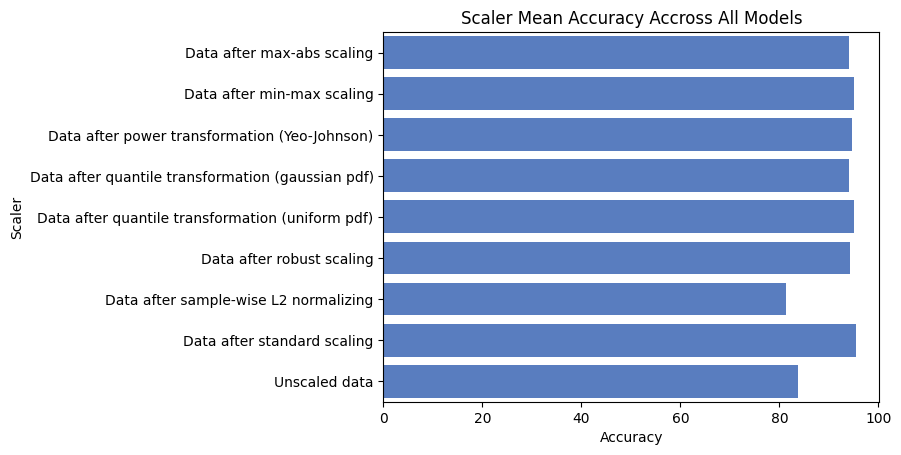

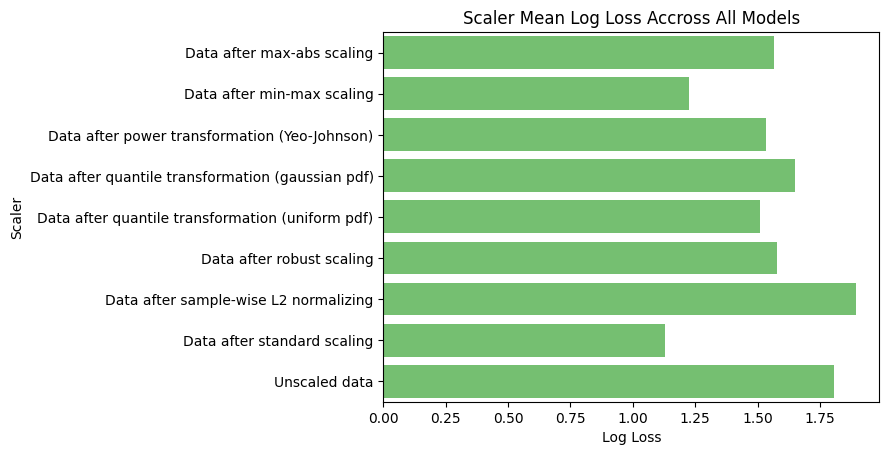

In [19]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()
sns.barplot(x='Accuracy',y='Scaler',data=scalers_g, color='b')
plt.title('Scaler Mean Accuracy Accross All Models')
plt.show()
plt.title('Scaler Mean Log Loss Accross All Models')
sns.barplot(x='Log Loss',y='Scaler',data=scalers_g, color='g')
plt.show()

## Recherche des hyperparamètres

In [17]:
RFC = RandomForestClassifier()
HGBC = HistGradientBoostingClassifier()

In [ ]:
X = df.drop(columns='classification')
y = df['classification']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

### Creation des dictionnaires pour la recherche des meilleurs hyperparamètres

In [ ]:
dico_rfc = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': [0.2,0.3,0.4,0.5],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [ ]:
dico_hgbc = {
    'learning_rate':[0.01, 0.1, 0.2, 0.5, 1],
    'max_iter':[50,100,200,300,500],
    'max_leaf_nodes':[3,15,31,62,128],
    'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf':[1,2,4,10,20],
}

### Oversampling et mise à l'échelle

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ros)
X_test_scaled = scaler.transform(X_test)

### Recherche à l'aide de recherche aléatoire des meilleurs paramètres

In [ ]:
rando_rfc = RandomizedSearchCV(RandomForestClassifier(), dico_rfc , n_iter=50, cv=3, n_jobs=-1, verbose=2, scoring='recall')
rando_hgbc = RandomizedSearchCV(HistGradientBoostingClassifier(), dico_hgbc, n_iter=50, cv=3, n_jobs=-1, verbose=2, scoring='recall')

In [ ]:
rando_rfc.fit(X_train_scaled,y_train)
rando_hgbc.fit(X_train_scaled,y_train)

In [ ]:
print("Best score:",rando_rfc.best_score_)

print(f"Best parameters: ")
pd.DataFrame(rando_rfc.best_params_.items(), columns=['Parameter','value'])

In [ ]:
print("Best score:",rando_hgbc.best_score_)

print(f"Best parameters: ")
pd.DataFrame(rando_hgbc.best_params_.items(), columns=['Parameter','value'])

In [ ]:
b_HGBC = HistGradientBoostingClassifier(min_samples_leaf=1,max_leaf_nodes=128,max_iter=300,max_depth=None,learning_rate=0.01)

In [ ]:
b_HGBC.fit(X_train_scaled,y_train_ros)

In [ ]:
y_pred = b_HGBC.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

In [ ]:
LSVC = LinearSVC()

In [ ]:
LSVC.fit(X_train_scaled,y_train_ros)

In [ ]:
y_pred = LSVC.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

## Tests de deep learning

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

In [ ]:
model=Sequential()

On crée les couches de neurones, ici avec autant de neurones que de features dans notre jeu de données

In [ ]:
model.add(Dense(24,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(24,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(24,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(24,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(1,activation='sigmoid')) #output is binary values so using sigmoid function
model.compile(optimizer='adam',loss='binary_crossentropy') #use binary_crossentropy as output is binary values

On crée une fonction d'interruption de l'apprentissage quand le modèle ne gagne plus en performances

In [ ]:
##model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=120,epochs=250)
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=30)

In [ ]:
model.fit(x=X_train_scaled,y=y_train_ros,epochs=50,validation_data=(X_test_scaled,y_test),callbacks=[early_stop])
#validation data is used to check for overfitting

Epoch 1/50
7/7 [==============================] - 2s 40ms/step - loss: 0.7460 - val_loss: 0.6156
Epoch 2/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6620 - val_loss: 0.5494
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 0.5810 - val_loss: 0.4964
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 0.5451 - val_loss: 0.4473
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 0.5118 - val_loss: 0.3952
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.4342 - val_loss: 0.3398
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.4102 - val_loss: 0.2843
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.3460 - val_loss: 0.2349
Epoch 9/50
7/7 [==============================] - 0s 10ms/step - loss: 0.3124 - val_loss: 0.1898
Epoch 10/50
7/7 [==============================] - 0s 7ms/step - loss: 0.2855 - val_loss: 0.1521
Epoch 11/50
7/7 [===================

In [ ]:
losses=pd.DataFrame(model.history.history)
losses #we get loss and validation loss

In [ ]:
losses.plot()
#if validation loss increases then data is overfitting

In [ ]:
predictions= model.predict(X_test_scaled)

3/3 [==============================] - 0s 3ms/step


In [ ]:
import math
from sklearn import metrics

#metrics to find accuracy of continous variables
print('Mean Abs value:' ,metrics.mean_absolute_error(y_test,predictions))
print('Mean squared value:',metrics.mean_squared_error(y_test,predictions))
print('root mean squared error value:',math.sqrt(metrics.mean_squared_error(y_test,predictions)))
print('explained_variance_score:',metrics.explained_variance_score(y_test,predictions)) #1 is good value

Ici on crée un masque pour retrouver des résultats binaires

In [ ]:
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in predictions]

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred_binary))
print("\n")
print(confusion_matrix(y_test,y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        35
         1.0       1.00      0.97      0.99        34

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



[[35  0]
 [ 1 33]]


Test avec une autre organisation des couches de neurones

In [ ]:
def nn():
    inputs = Input(name='inputs', shape=[X_train_shape.shape[1],])
    layer = Dense(128, name='FC1')(inputs)
    layer = BatchNormalization(name='BC1')(layer)
    layer = Activation('relu', name='Activation1')(layer)
    layer = Dropout(0.3, name='Dropout1')(layer)
    layer = Dense(128, name='FC2')(layer)
    layer = BatchNormalization(name='BC2')(layer)
    layer = Activation('relu', name='Activation2')(layer)
    layer = Dropout(0.3, name='Dropout2')(layer)
    layer = Dense(128, name='FC3')(layer)
    layer = BatchNormalization(name='BC3')(layer)
    layer = Dropout(0.3, name='Dropout3')(layer)
    layer = Dense(1, name='OutLayer')(layer)
    layer = Activation('sigmoid', name='sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
model = nn()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=X_train_scaled, y=y_train_ros, epochs=200, validation_data=(X_test_scaled, y_test), callbacks=[reduce_lr, early_stopping], verbose=2)

In [ ]:
predictions = model.predict(X_test_scaled)

3/3 [==============================] - 0s 5ms/step


In [ ]:
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in predictions]

In [ ]:
print(classification_report(y_test,y_pred_binary))
print("\n")
print(confusion_matrix(y_test,y_pred_binary))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       1.00      1.00      1.00        34

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



[[35  0]
 [ 0 34]]


In [18]:
variables = {
    "age": "Âge",
    "bp": "Pression artérielle",
    "sg": "Gravité spécifique",
    "al": "Albumine",
    "su": "Sucre",
    "rbc": "Globules rouges Count",
    "pc": "Cellules pus",
    "pcc": "Cellules pus dans l'urine",
    "ba": "Bactéries",
    "bgr": "Glucose sanguin aléatoire",
    "bu": "Urée sanguine",
    "sc": "Créatinine sérique",
    "sod": "Sodium",
    "pot": "Potassium",
    "hemo": "Hémoglobine",
    "pcv": "Volume globulaire moyen",
    "wc": "Leucocytes",
    "rc": "Globules rouges",
    "htn": "Hypertension",
    "dm": "Diabète",
    "cad": "Maladie artérielle coronaire",
    "appet": "Appétit",
    "pe": "Œdème périphérique",
    "ane": "Anémie",
    "classification": "target"
}

In [21]:
df.rename(columns=variables)

,Albumine,Sucre,Globules rouges Count,Cellules pus,Cellules pus dans l'urine,Bactéries,Hypertension,Diabète,Maladie artérielle coronaire,Appétit,...,Gravité spécifique,Glucose sanguin aléatoire,Urée sanguine,Créatinine sérique,Sodium,Potassium,Hémoglobine,Volume globulaire moyen,Leucocytes,Globules rouges
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.020,121.0,36.0,1.2,139.0,4.4,15.4,44.0,7800.0,5.200000
2,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.010,423.0,53.0,1.8,139.0,4.4,9.6,31.0,7500.0,4.762041
3,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.005,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.900000
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.010,106.0,26.0,1.4,139.0,4.4,11.6,35.0,7300.0,4.600000
5,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.015,74.0,25.0,1.1,142.0,3.2,12.2,39.0,7800.0,4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.020,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.900000
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.025,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.200000
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.020,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.400000
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.025,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.900000


In [ ]:
X_test_shape = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_shape = pd.DataFrame(X_train_scaled, columns=X_train.columns)

## Explicabilité des modèles

In [ ]:
from sklearn.linear_model import LassoCV
import shap

Nous allons réaliser un lassoCV qui permet d'améliorer l'interpretabilité d'un modèle en éliminant certaines features

In [ ]:
reg = LassoCV()
reg.fit(X_train_shape, y_train_ros)

LassoCV()

In [ ]:
best_alpha = reg.alphas_[np.argmin(reg.mse_path_.mean(axis=-1))]

In [ ]:
print("Best alpha using built-in LassoCV: %f" % best_alpha)
print("Best score using built-in LassoCV: %f" %reg.score(X_train_shape,y_train_ros))
coef = pd.Series(reg.coef_, index = X_train_shape.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Best alpha using built-in LassoCV: 0.022120
Best score using built-in LassoCV: 0.777189
Lasso picked 11 variables and eliminated the other 13 variables


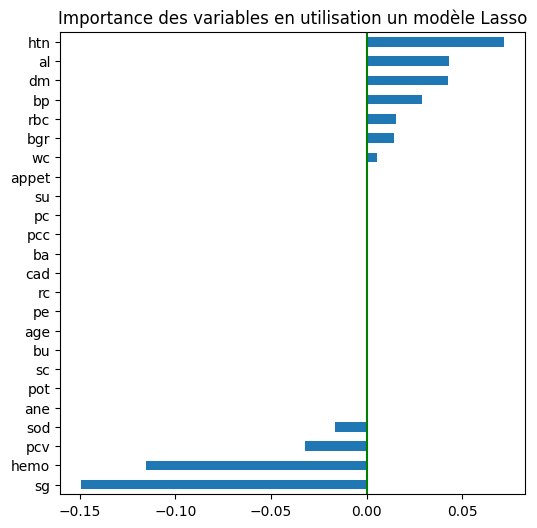

In [ ]:
fig = plt.figure(figsize=(6,6))
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.axvline(x=0, color='g')
plt.title("Importance des variables en utilisation un modèle Lasso")
fig.savefig('importance_graph.png', dpi=200, bbox_inches = 'tight') ;

Ici nous réintégrons les noms des colonnes afin de savoir à quelle variable se réfèrent nos graphiques suivant

In [ ]:
X_test_shape = pd.DataFrame(X_test_scaled, columns=X_train.columns)
X_train_shape = pd.DataFrame(X_train_scaled, columns=X_train.columns)

Nous allons ici étudier les SHAP values qui permettent de déterminer l'impact de chaque feature sur les prédictions de notre modèle

In [ ]:
explainer = shap.KernelExplainer(model.predict,X_train_shape)

7/7 [==============================] - 0s 2ms/step


In [ ]:
shap_values = explainer.shap_values(X_test_shape,nsamples=100)

  0%|          | 0/69 [00:00<?, ?it/s]

663/663 [==============================] - 1s 1ms/step


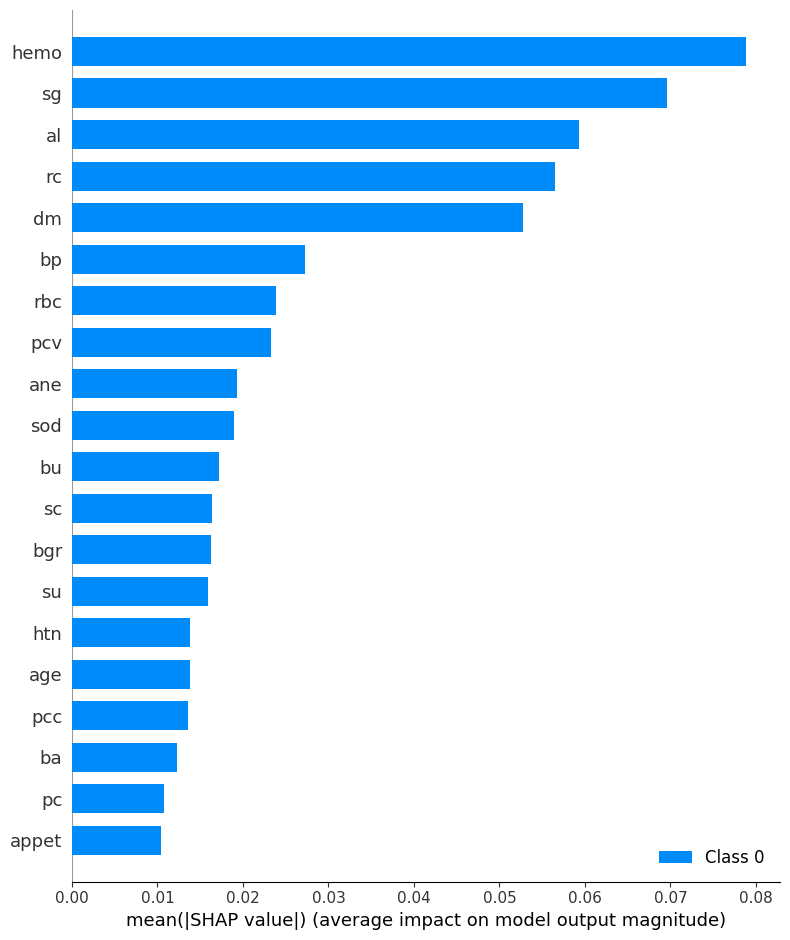

In [ ]:
shap.summary_plot(shap_values,X_test_shape)

In [ ]:
explainer.expected_value

array([0.50271194])

<Figure size 2000x1000 with 0 Axes>

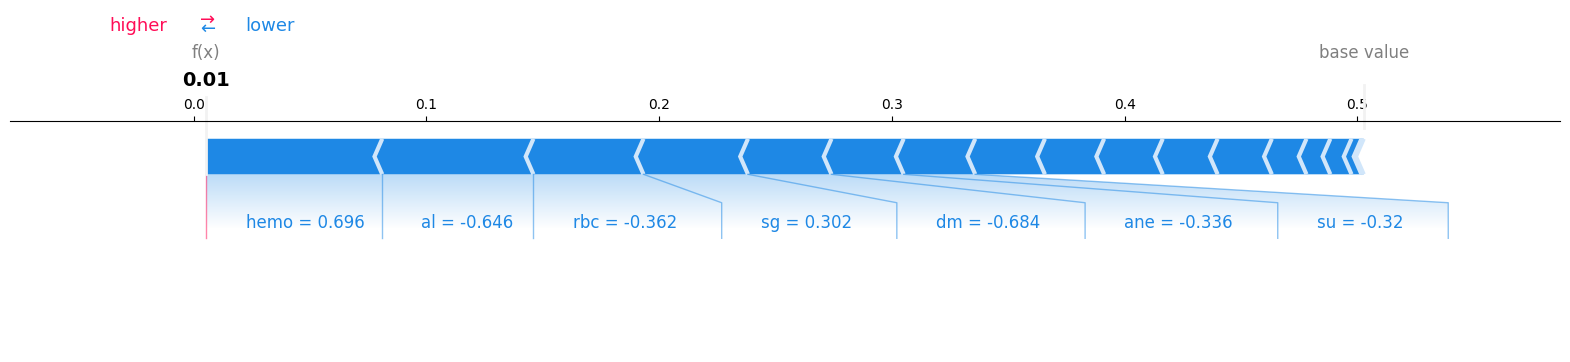

In [ ]:
shap.initjs()
num_test = 2
fig = plt.figure(figsize=(20,10))
shap.force_plot(explainer.expected_value, shap_values[0][num_test,:], X_test_scaled[num_test,:].round(3), feature_names=X.columns, matplotlib=True, show=False)
plt.savefig('force_plot.png')

<Figure size 2000x1000 with 0 Axes>

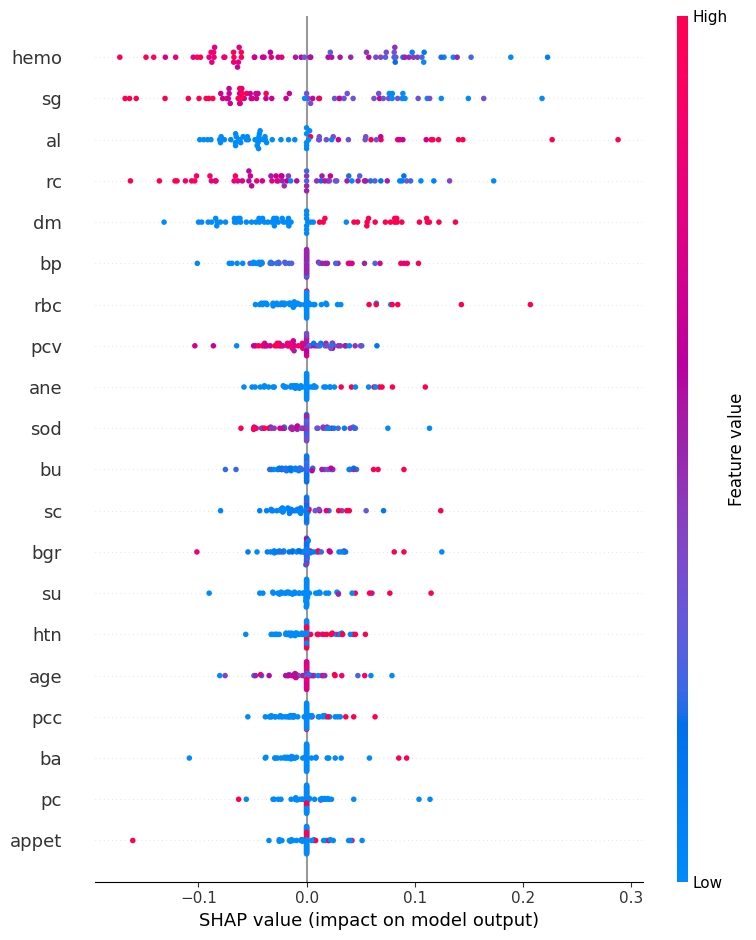

In [ ]:
shap.initjs()

fig = plt.figure(figsize=(20,10))
shap.summary_plot(shap_values[0], X_test_shape)
plt.savefig('force_plot.png')

<Figure size 640x480 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

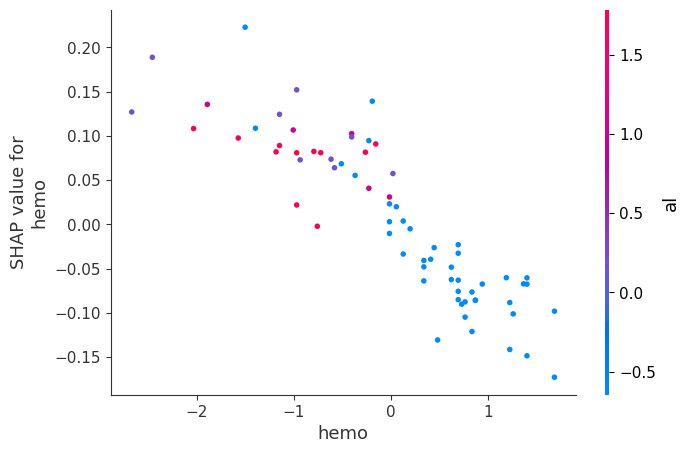

In [ ]:
shap.initjs()
fig = plt.figure(figsize=(20,10))
shap.dependence_plot("hemo",shap_values[0], X_test_shape, interaction_index='al', show=True)
plt.savefig('dependence_plot.png')